In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="ticks", palette="husl", color_codes=True)

from astropy.io import fits

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")



In [2]:
from pyHIIExplorer.HIIblob import *
import time

In [3]:
from pyFIT3D.common.io import get_wave_from_header


# paths
inp_path = "../../_fitting-data/IC342/obs/"
pointing = "manga-9675-12705"
# pointing = "manga-12050-12705"
cube_path = os.path.join(inp_path, f"{pointing}.cube.fits.gz")
cube__wyx, cube_header = fits.getdata(cube_path, header=True)
wave__w = get_wave_from_header(cube_header, 3)
clean_mask = (cube__wyx==0).all(axis=0)

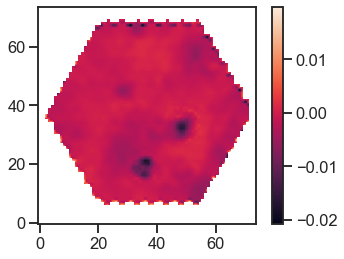

In [4]:
# V-image: collapse all wavelengths
mask_v = (3800<=wave__w)&(wave__w<=9500)
v_image = np.ma.masked_array(cube__wyx[mask_v].mean(axis=0), mask=clean_mask)
# Halpha: 4500-6000
mask_ha = (4500<=wave__w)&(wave__w<=6000)
ha_image = np.ma.masked_array(cube__wyx[mask_ha].mean(axis=0), mask=clean_mask)
# ha_image = np.ma.masked_array(cube__wyx[np.argmin(np.abs(wave__w-6563))], mask=clean_mask)

plt.imshow(v_image-ha_image, origin="lower")
plt.colorbar()

0.025970262
# 1sig Ha-map =  0.01298513077199459 ; 1sig MUSE-V  0.01298513077199459
# HII reg. Initial =  2
# HII reg. 2nd =  2
# HII reg. additional =  0
# Last iteration Num. =  2
# Clean above 3sigma Num =  2
# X_sqr =  0.33816881772524443
# HII reg clean= 2


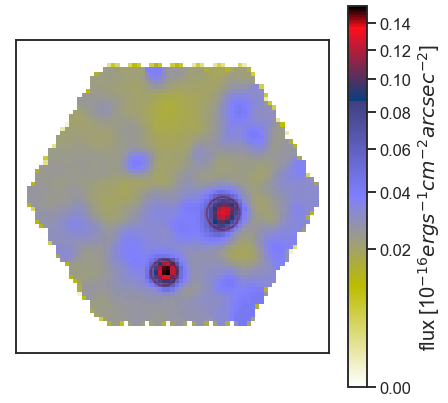

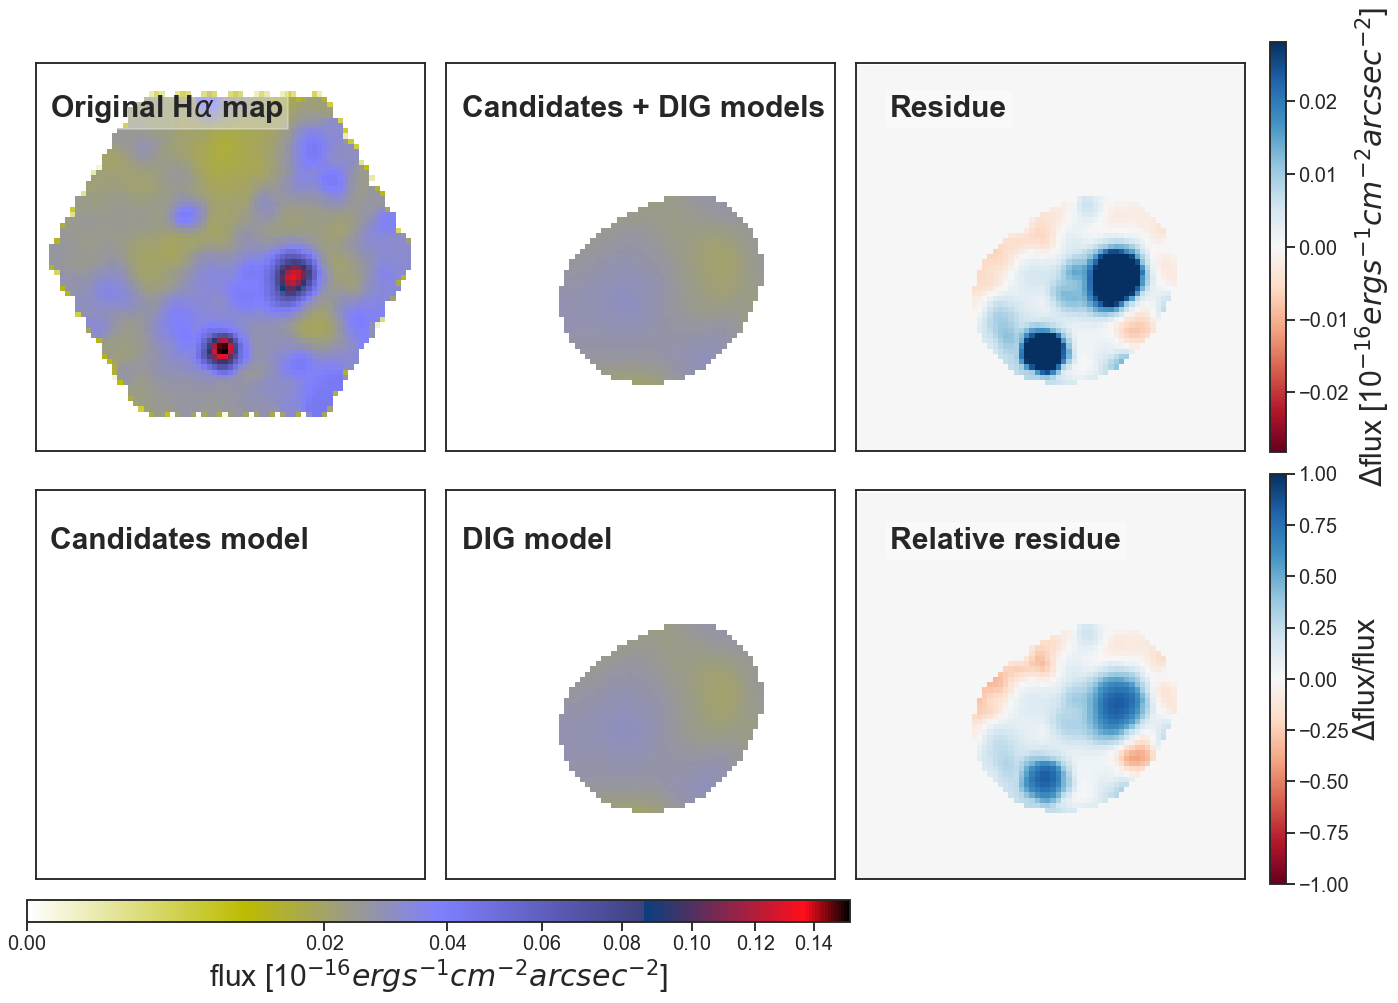

In [5]:
median_ha = np.ma.median(ha_image)
print(median_ha)

blobs_final,blobs_F_Ha,image_HII,diff_map_final,diff_points,diff_Flux=HIIblob(ha_image,v_image, 2.5/0.5, MUSE_1sig=median_ha/2, MUSE_1sig_V=0, plot=1, refined=5, max_size=3.)

0.01238291943127696
# 1sig Ha-map =  0.01238291943127696 ; 1sig MUSE-V  0.01238291943127696
# HII reg. Initial =  2
# HII reg. 2nd =  2
# HII reg. additional =  0
# Last iteration Num. =  2
# Clean above 3sigma Num =  2
# X_sqr =  0.28654191412799623
# HII reg clean= 2


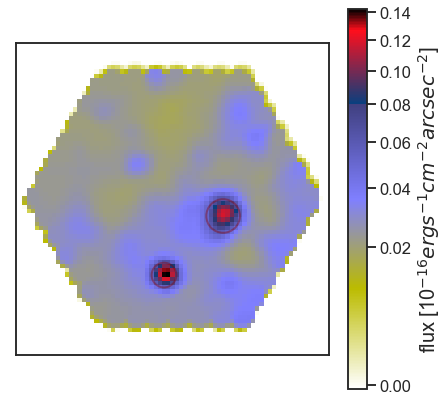

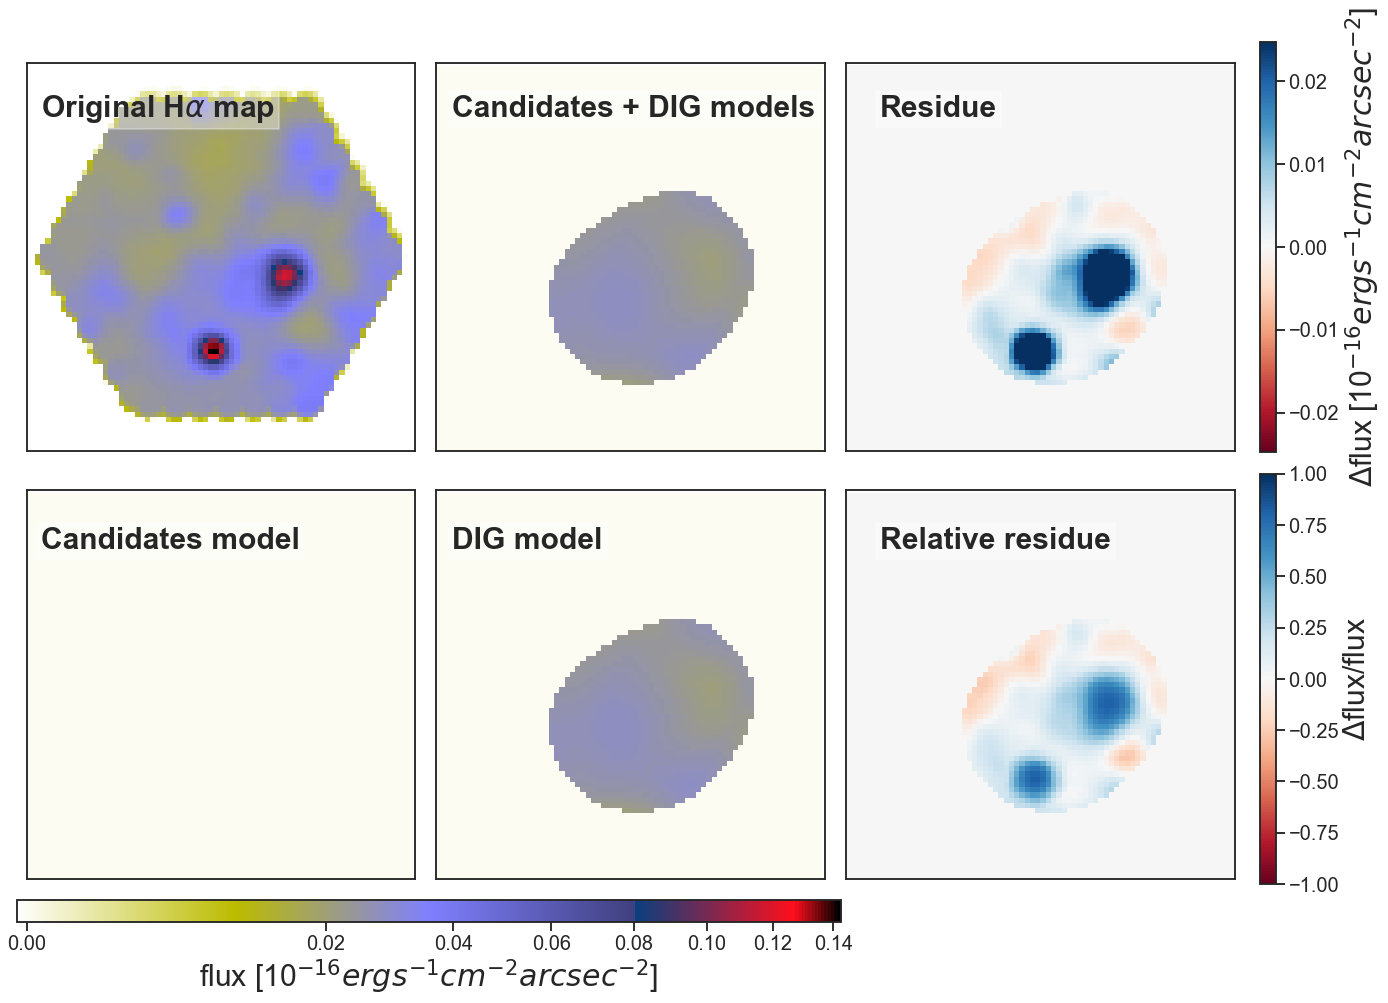

In [6]:
std_v = np.ma.std(v_image)
print(std_v)

blobs_final,blobs_F_Ha,image_HII,diff_map_final,diff_points,diff_Flux=HIIblob(v_image,v_image, 2.5/0.5, MUSE_1sig=std_v, MUSE_1sig_V=0, plot=1, refined=5, max_size=3.)

In [7]:
std_v = np.ma.std(v_image)
print(std_v)

blobs_final,blobs_F_Ha,image_HII,diff_map_final,diff_points,diff_Flux=HIIblob(v_image,v_image, 2.5/0.5, MUSE_1sig=std_v, MUSE_1sig_V=0, plot=0, refined=5, max_size=3.)


nstars = blobs_final.shape[0]

image_HII_cube = np.zeros_like(cube__wyx)
rss_spec = np.zeros((wave__w.size, nstars))
for i in range(wave__w.size):
    ha_image = np.ma.masked_array(cube__wyx[i,:,:], mask=clean_mask)
    rss_spec[i,:],image_HII_cube[i,:,:],diff_map_final,diff_points,diff_Flux=HIIextraction(ha_image,blobs_final,kind=0,we=1,FWHM_MUSE = 2.5/0.5, refined = 0)

0.01238291943127696
# 1sig Ha-map =  0.01238291943127696 ; 1sig MUSE-V  0.01238291943127696
# HII reg. Initial =  2
# HII reg. 2nd =  2
# HII reg. additional =  0
# Last iteration Num. =  2
# Clean above 3sigma Num =  2
# X_sqr =  0.28654191412799623
# HII reg clean= 2


In [8]:
from pyFIT3D.common.io import array_to_fits


header = {}
header["CRPIX1"] = cube_header["CRPIX3"]
header["CRVAL1"] = cube_header["CRVAL3"]
header["CDELT1"] = cube_header["CDELT3"]

array_to_fits(f"_data/star-mask/CS.{pointing}-stars.RSS.fits.gz", rss_spec.T, header=header, overwrite=True)
array_to_fits(f"_data/star-mask/e_CS.{pointing}-stars.RSS.fits.gz", np.sqrt(np.abs(rss_spec)).T, header=header, overwrite=True)

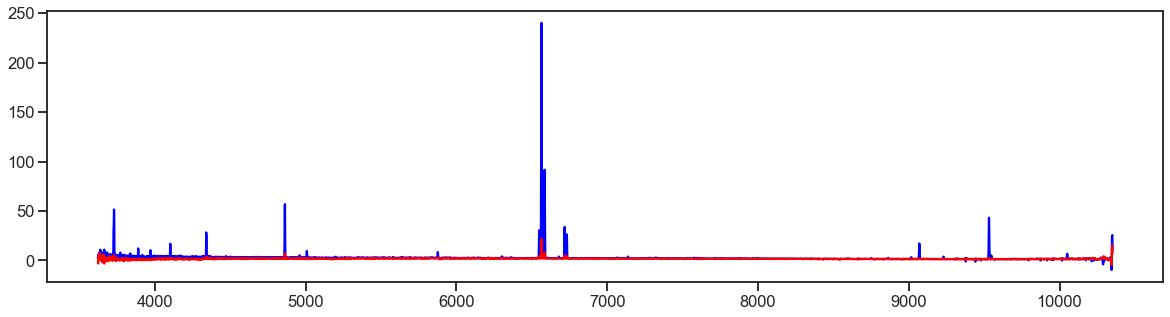

In [9]:
plt.figure(figsize=(20,5))
plt.plot(wave__w, rss_spec[:,0], "-b", wave__w, rss_spec[:,1], "-r")

# fit dap
# extract stellar component
# run create_HII_image

In [10]:
from lvmdap._cmdline import dap

obs_path = "../../_fitting-data/IC342/"
# using the initial values:
#
# Instrumental dispersion: 2.5 AA
sigma_inst = 0.001

# Velocity dispersion of the gas in AA
sigma_gas = 3.7

# Masks:
#     File with list of ranges of wavelength to be masked in whole analysis
mask_list = None#'../../_fitting-data/_configs/mask_elines.txt'

######################
######################
# Non linear analysis: (redshift, observed dispersion and dust attenuation)
#     wavelength range: 
#         [3850, 4700] AA for the redshift and sigma analysis
#         [3800, 7000] AA for the dust attenuation
w_min_max = [3800, 9500]
nl_w_min_max = [4700, 6000]

#     models:
#         Miles solar 3 models
ssp_nl_fit_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-5.fits.gz'

#     emission lines to be masked:
elines_mask_file = '../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt'

#     redshift:
#         initial value: 0.02449
#                 delta: 0.0001
#                   min: 0.02349
#                   max: 0.02549
redshift_set = [0.0001, 0, -0.5, 0.5]

#     dispersion: (km/s)
#         initial value: 30
#                 delta: 20
#                   min: 1
#                   max: 150
sigma_set = [0, 0, 0, 350]

#     dust attenuation at V band (mag):
#         initial value: 0.3
#                 delta: 0.15
#                   min: 0
#                   max: 1.6
AV_set = [0, 0.1, 0, 2.5]

ssp_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-100.fits.gz'
par_file = '../../_fitting-data/_basis_mastar_v2/stellar-basis-params-100.fits.gz'

# plot options
stellar_param = fits.open(par_file, memmap=False)

labels = {"TEFF":r"$\log{T_\text{eff}}$", "LOGG":r"$\log{g}$", "MET":r"$[\text{Fe}/\text{H}]$", "ALPHAM":r"$[\alpha/\text{Fe}]$"}
cmap = "binary_r"
color = sns.color_palette(cmap)[0]



sed_file = os.path.join("_data/star-mask", f"CS.{pointing}-stars.RSS.fits.gz")
err_file = os.path.join("_data/star-mask", f"e_CS.{pointing}-stars.RSS.fits.gz")
label = os.path.basename(sed_file).replace(".RSS.fits.gz","").replace("CS.","")

cmdline = f"{sed_file} {ssp_file} {sigma_inst} {label} --input-fmt rss --error-file {err_file} --rsp-nl-file {ssp_nl_fit_file} --w-range {' '.join(map(str,w_min_max))} --w-range-nl {' '.join(map(str,nl_w_min_max))} --redshift {' '.join(map(str,redshift_set))} --sigma {' '.join(map(str,sigma_set))} --AV {' '.join(map(str,AV_set))} --sigma-gas {sigma_gas} --emission-lines-file {elines_mask_file} -cd --single-gas-fit --output-path _data/star-mask".split()

dap._main(cmdline)

'COMMAND LINE ARGUMENTS'
('Namespace(AV=[0.0, 0.1, 0.0, 2.5], RV=3.1, clear_outputs=True, '
 'config_file=None, debug=True, '
 "emission_lines_file='../../_fitting-data/_configs/MaNGA/emission_lines_long_list.txt', "
 "error_file='_data/star-mask/e_CS.manga-9675-12705-stars.RSS.fits.gz', "
 "ext_curve='CCM', flux_scale=[-inf, inf], ignore_gas=False, input_fmt='rss', "
 "label='manga-9675-12705-stars', mask_file=None, n_mc=20, "
 "output_path='_data/star-mask', plot=0, redshift=[0.0001, 0.0, -0.5, 0.5], "
 "rsp_file='../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-100.fits.gz', "
 "rsp_nl_file='../../_fitting-data/_basis_mastar_v2/stellar-basis-spectra-5.fits.gz', "
 'sigma=[0.0, 0.0, 0.0, 350.0], sigma_gas=3.7, sigma_inst=0.001, '
 'single_gas_fit=True, single_rsp=False, '
 "spec_file='_data/star-mask/CS.manga-9675-12705-stars.RSS.fits.gz', "
 'verbose=False, w_range=[3800.0, 9500.0], w_range_nl=[4700.0, 6000.0])\n')

# ID 0/1 ===============================================


In [11]:
rss_model = fits.open(f"_data/star-mask/output.{label}.fits.gz")
rss_model[0].data.shape

(6, 2, 4487)

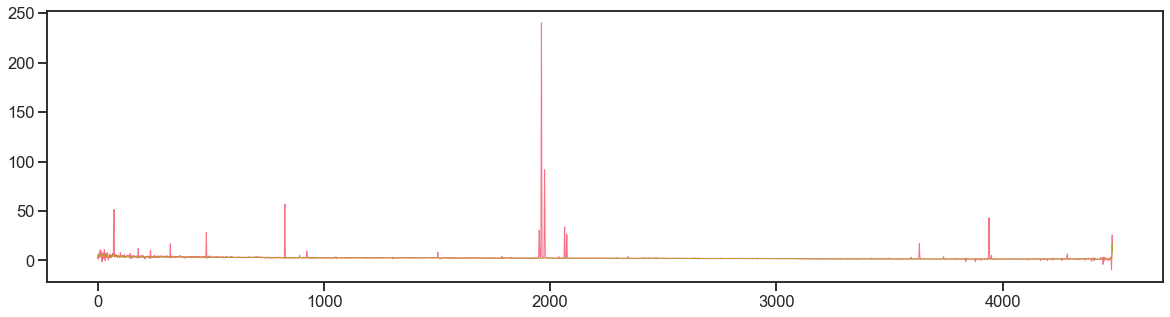

In [12]:
plt.figure(figsize=(20,5))

plt.plot(rss_model[0].data[0,0,:], lw=1)
plt.plot(rss_model[0].data[1,0,:], lw=1)

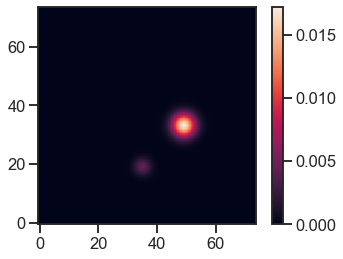

In [13]:
rss_model = fits.open(f"_data/star-mask/output.{label}.fits.gz")


rss_model_spec = rss_model[0].data[1,:,:].T

_, ny, nx = cube__wyx.shape

image_stars_cube = np.zeros_like(cube__wyx)
blobs_final_norm = blobs_final.copy()
blobs_final_norm[:,2] = blobs_final_norm[:,2]/np.sqrt(2)

for i in range(wave__w.size):
    image_stars_cube[i,:,:] = create_HII_image(blobs_final_norm,rss_model_spec[i,:],ny,nx,dr=5)

plt.imshow((image_HII_cube-image_stars_cube).mean(axis=0), origin="lower")
plt.colorbar()

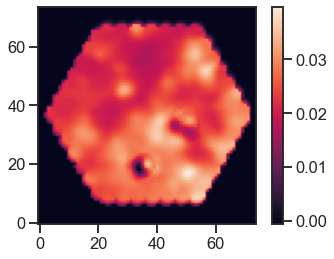

In [14]:
array_to_fits(f"{pointing}.GAS.fits.gz", (cube__wyx-image_stars_cube), header=cube_header, overwrite=True)

plt.imshow((cube__wyx-image_stars_cube).mean(axis=0), origin="lower")
plt.colorbar()

In [15]:
blobs_F_Ha,image_HII,diff_map_final,diff_points,diff_Flux=HIIextraction(ha_image,blobs_final,kind=0,we=1,FWHM_MUSE = 2.5/0.5, refined = 0)

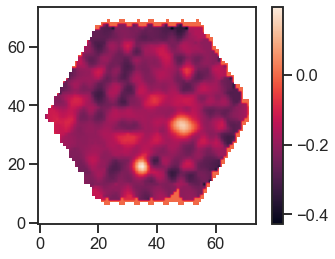

In [16]:
plt.imshow((image_HII-ha_image), origin="lower")
plt.colorbar()
# plt.figure()
# plt.imshow(, origin="lower")

In [17]:
# run pyHIIExplorer to detect point sources
# remove point sources detected from IC342 and LMC
# 